In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec, in_signal, n_samples, out_signal=None):
    plt.figure()
    plt.subplot(1,1,1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6, in_signal[:n_samples], 'y-', label='input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6, out_signal[:n_samples], 'g-', linewidth=2, label='FIR Output')
        
    plt.legend()

Number of samples:  20000


<IPython.core.display.Javascript object>


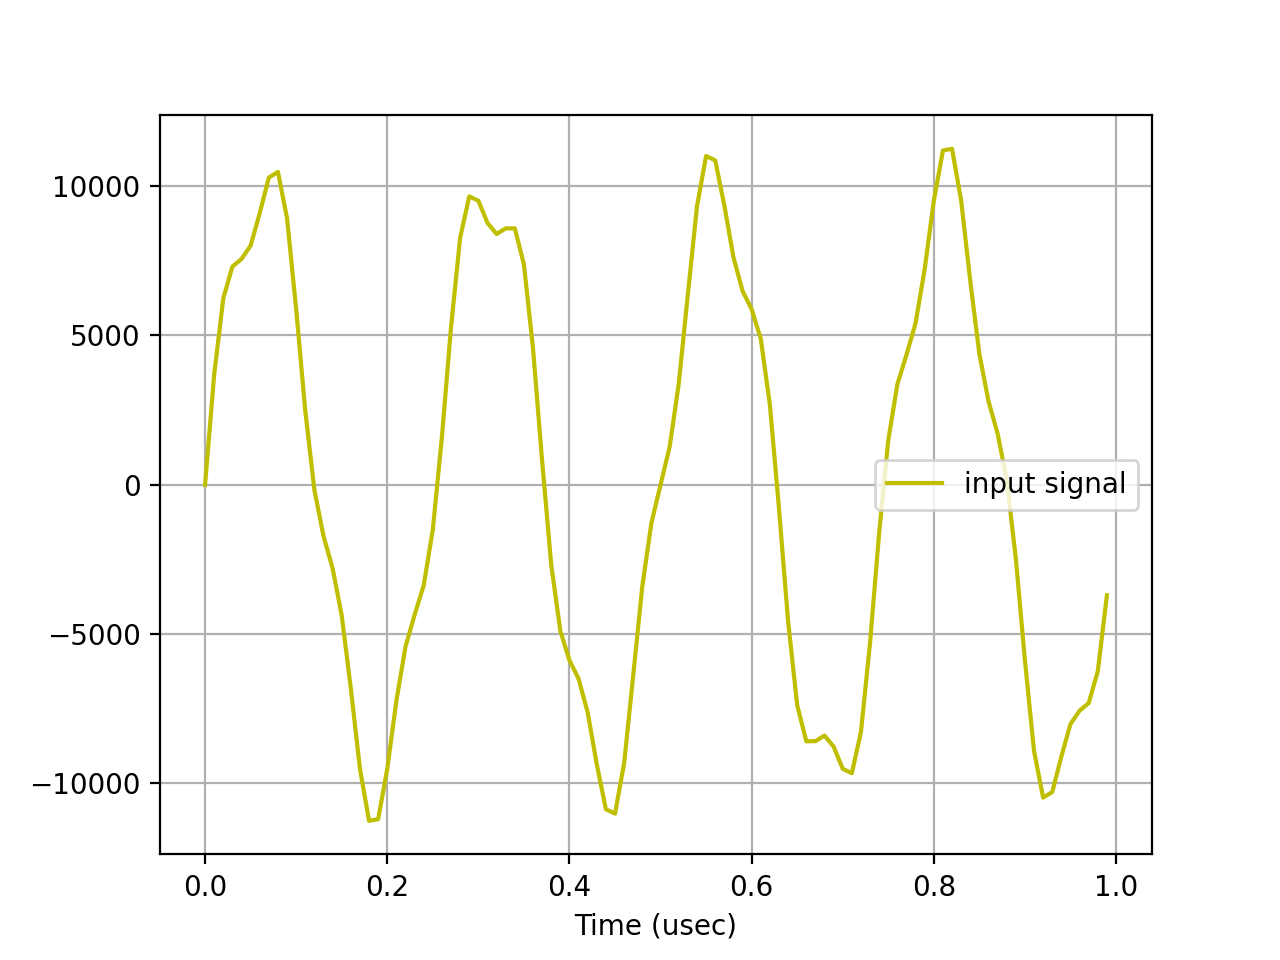

In [2]:
import numpy as np

T = 0.0002
fs = 100000000 # sampling frequency: 100 MHz
n = int(T*fs)
t = np.linspace(0, T, n, endpoint=False)
samples = 10000 * np.sin(2*np.pi*t*4000000) + 1500 * np.sin(2*np.pi*t*15000000) # 4 MHz sine wave + 15 MHz sine wave
samples = samples.astype(np.int16)
print('Number of samples: ', len(samples))

plot_to_notebook(t, samples, 100)

SOFTWARE FIR EXECUTION TIME: 12.4710 ms


<IPython.core.display.Javascript object>


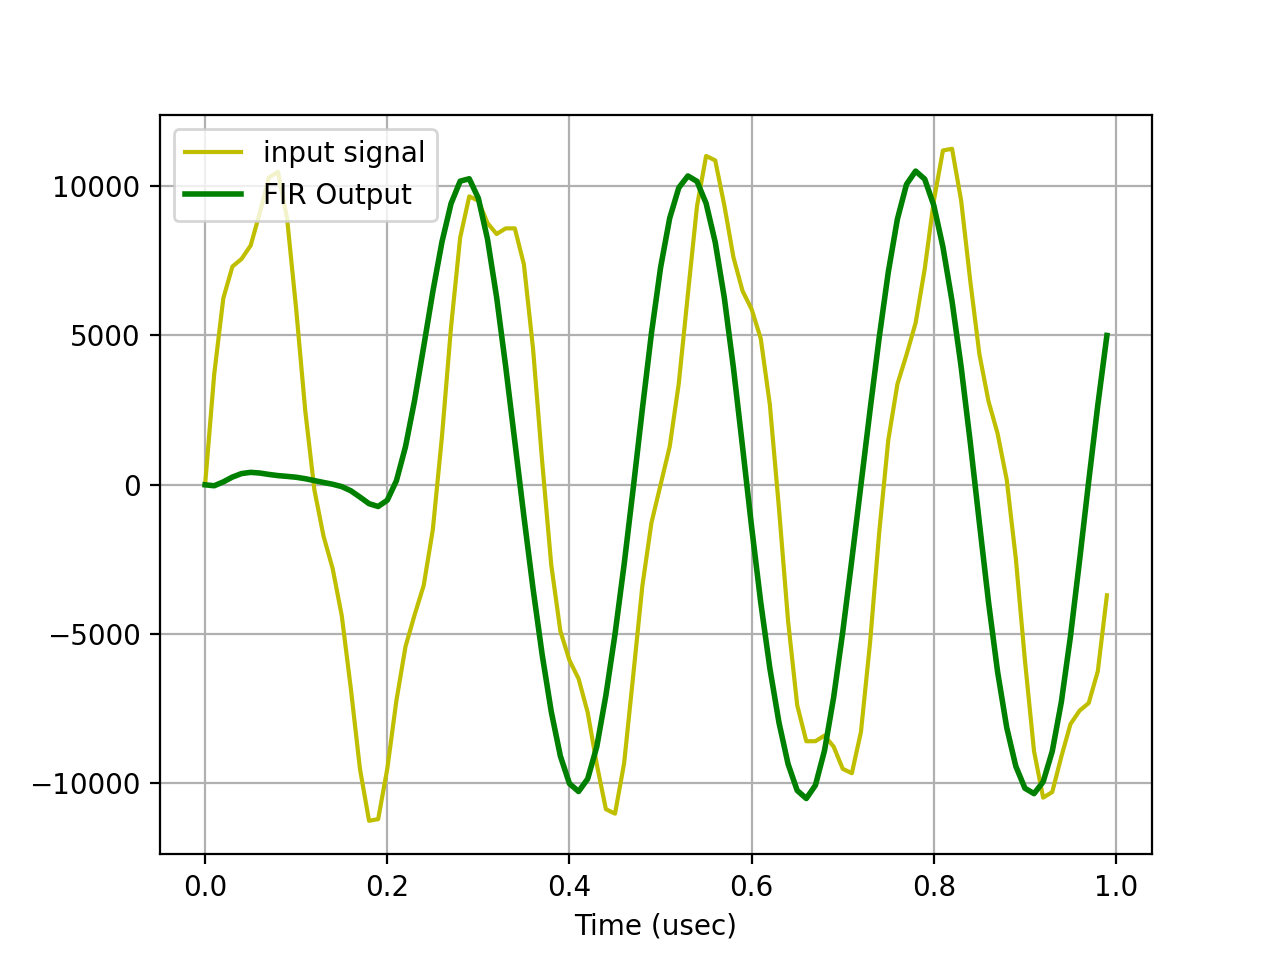

In [3]:
from scipy.signal import lfilter
import time

coeffs = [-0.00875854,  0.04141235,  0.01757812,  0.00823975, -0.00152588, -0.01113892,
 -0.01669312, -0.01473999, -0.00497437,  0.00930786,  0.02175903,  0.02578735,
  0.01751709, -0.00210571, -0.02609253, -0.04367065, -0.04370117, -0.01934814,
  0.0289917,   0.09240723,  0.15591431,  0.20275879,  0.22000122,  0.20275879,
  0.15591431,  0.09240723,  0.0289917,  -0.01934814, -0.04370117, -0.04367065,
 -0.02609253, -0.00210571,  0.01751709,  0.02578735,  0.02175903,  0.00930786,
 -0.00497437, -0.01473999, -0.01669312, -0.01113892, -0.00152588,  0.00823975,
  0.01757812,  0.04141235, -0.00875854]

start_time = time.time()
sw_fir_output = lfilter(coeffs, [1.0], samples) # Apply our FIR filter on CPU
stop_time = time.time()
sw_exec_time = stop_time - start_time
print(f"SOFTWARE FIR EXECUTION TIME: {sw_exec_time*1e3:.4f} ms")

sw_fir_output = sw_fir_output.astype(np.int16)
plot_to_notebook(t, samples, 100, out_signal=sw_fir_output)

In [4]:
from pynq import Overlay
from pynq import allocate
import numpy as np

ol = Overlay("./overlay/fir.bit")

In [5]:
ol?

In [6]:
print(ol.ip_dict.keys())

dict_keys(['fir', 'axi_dma_0', 'processing_system7_0'])


In [7]:
fir = ol.fir
dma = ol.axi_dma_0

In [8]:
fir.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0)
}

In [9]:
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

In [10]:
in_buffer = allocate(shape=(n,), dtype=np.int16)
out_buffer = allocate(shape=(n,), dtype=np.int16)

In [11]:
np.copyto(in_buffer, samples)

In [12]:
print(f"In Buffer Address: {hex(in_buffer.device_address)}")
print(f"Out Buffer Address: {hex(out_buffer.device_address)}")

In Buffer Address: 0x15850000
Out Buffer Address: 0x15860000


In [13]:
fir.write(0x00, 0x81)
fir.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0)
}

In [14]:
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
# dma.sendchannel.wait()
# dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time - start_time

print(f"HARDWARE FIR EXECUTION TIME: {hw_exec_time*1e3:.4f} ms")
print(f"SOFTWARE FIR EXECUTION TIME: {sw_exec_time*1e3:.4f} ms")
print(f"HARDWARE ACCELERATION FACTOR: {sw_exec_time / hw_exec_time:.2f}")

HARDWARE FIR EXECUTION TIME: 2.4116 ms
SOFTWARE FIR EXECUTION TIME: 12.4710 ms
HARDWARE ACCELERATION FACTOR: 5.17


In [15]:
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=1, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=361037824),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=40000),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SG

<IPython.core.display.Javascript object>


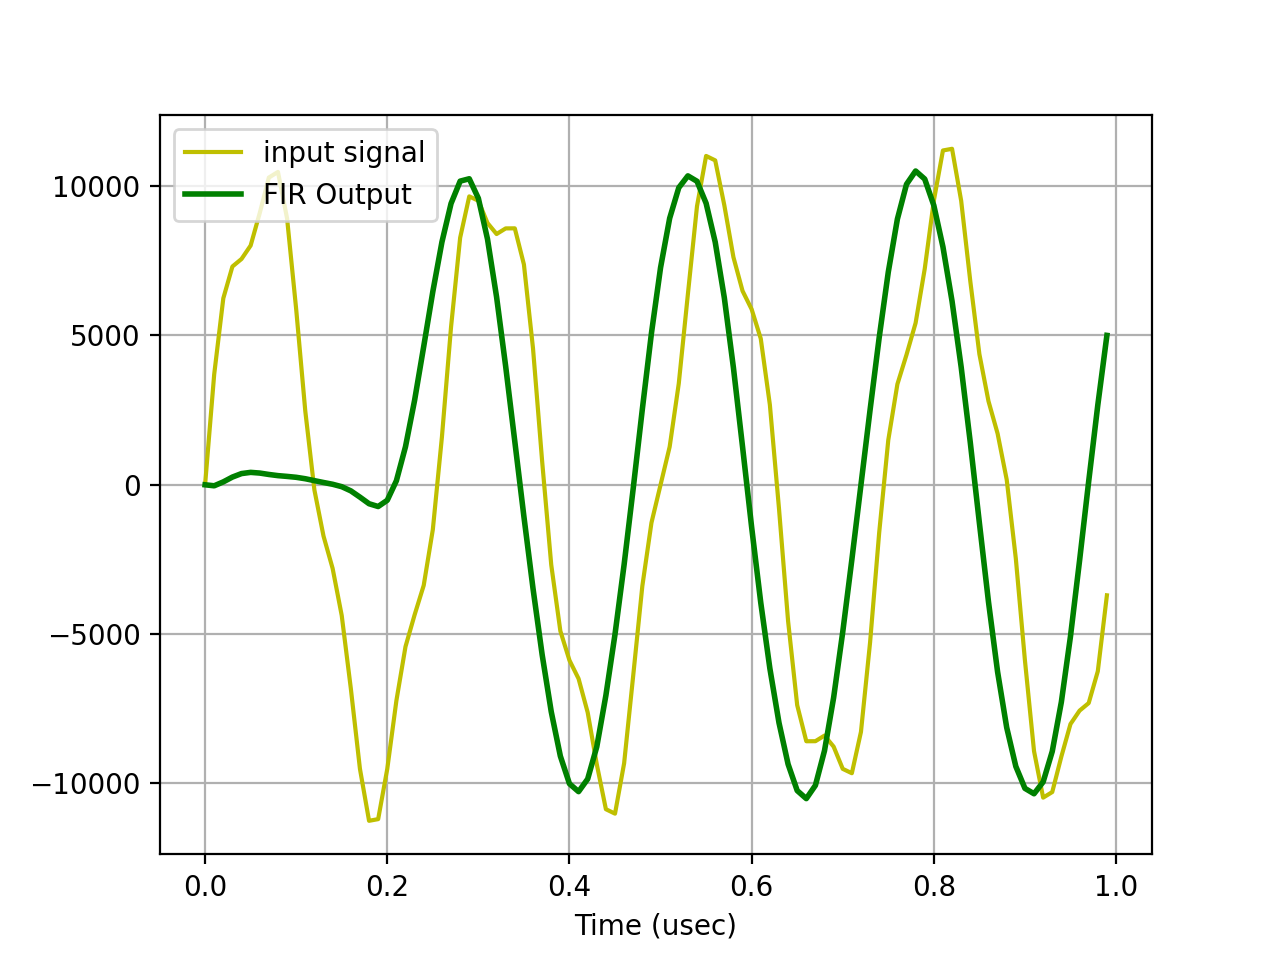

In [16]:
plot_to_notebook(t, samples, 100, out_signal=out_buffer)

In [17]:
print(len(sw_fir_output))
print(len(out_buffer))
print(f"Arrays are equal: {np.array_equal(sw_fir_output, out_buffer)}")
print(sw_fir_output[-50:])
print(out_buffer[-50:])

20000
20000
Arrays are equal: False
[  7268   8922   9944  10340  10159   9424   8124   6262   3917   1274
  -1421  -3943  -6145  -7961  -9349 -10234 -10503 -10060  -8896  -7121
  -4926  -2505      0   2505   4926   7121   8896  10060  10503  10234
   9349   7961   6145   3943   1421  -1274  -3917  -6262  -8124  -9424
 -10159 -10340  -9944  -8922  -7268  -5073  -2531    116   2668   5001]
[  7270   8924   9946  10343  10162   9426   8126   6263   3918   1274
  -1422  -3945  -6148  -7965  -9353 -10238 -10507 -10063      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]


In [18]:
del in_buffer, out_buffer

In [19]:
print(f"In Buffer Address: {hex(in_buffer.device_address)}")
print(f"Out Buffer Address: {hex(out_buffer.device_address)}")

NameError: name 'in_buffer' is not defined